In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FuncFormatter
import scipy.stats as st
import scipy.special as sp
import scipy.interpolate as si
import seaborn as sns
import emcee as mc
plt.rc('font', size=12.0)

In [3]:
m_em = ['Mns_6304', 'Mns_6397',  'Mns_M13',   'Mns_M28',  'Mns_M30',  'Mns_wCen',
         'Mns_X7',   'Mns_1810b', 'Mns_1724b', 'Mns_1702', 'Mns_0030', 'Mns_0740']
r_em = ['Rns_6304', 'Rns_6397',  'Rns_M13',   'Rns_M28',  'Rns_M30',  'Rns_wCen',
         'Rns_X7',   'Rns_1810b', 'Rns_1724b', 'Rns_1702', 'Rns_0030', 'Rns_0740']
m_gw = ['m1_gw17', 'm2_gw17', 'm1_gw19', 'm2_gw19']
m_pop = ['M_J0453p', 'M_J0453c', 'M_J1906p', 'M_J1906c', 'M_B1534p', 'M_B1534c',
        'M_B1913p', 'M_B1913c', 'M_B2127p', 'M_B2127c', 'M_J0737A', 'M_J0737B',
        'M_J1756p', 'M_J1756c', 'M_J1807p', 'M_J1807c', 'M_J1518p', 'M_J1518c',
        'M_J1811p', 'M_J1811c', 'M_J1829p', 'M_J1829c', 'M_J2045',  'M_J2053',
        'M_J1713',  'M_B1855',  'M_J0751',  'M_J1141',  'M_J1738',  'M_J1614',
        'M_J0348',  'M_J2222',  'M_J2234',  'M_J1949',  'M_J1012',  'M_J0437',
        'M_J1909',  'M_J1802',  'M_J1911',  'M_J2043',  'M_J0337',  'M_J1946',
        'M_J1918',  'M_J1600',  'M_J0621',  'M_B2303',  'M_J0024',  'M_J0514',
        'M_B1516',  'M_J1748I', 'M_J1748J', 'M_B1802',  'M_B1911',  'M_J0740',
        'M_CygX2',  'M_XTEJ2123',           'M_4U1822', 'M_HerX1',  'M_2S0921']

model = ['ml', 'mp', 'nl', 'np']
label = ['ML', 'MP', 'NL', 'NP']
hc = 197.32698

## 1. Posterior Plots

### 1.1 Maximum Masses

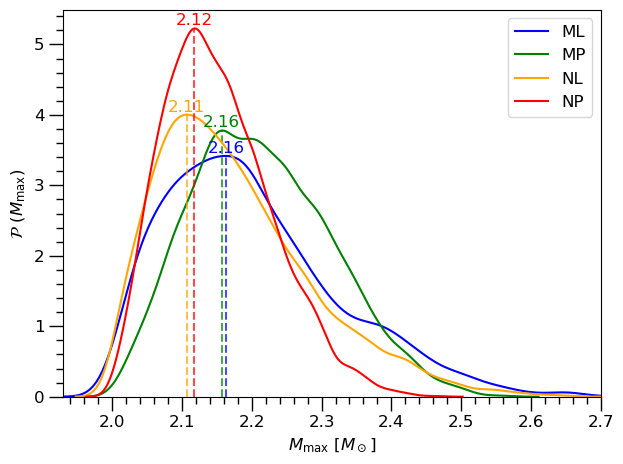

In [3]:
# Define colors for each plot for consistency
colors = ['blue', 'green', 'orange', 'red']

# Loop through each dataset and plot the KDE with peak markers
for k in range(4):
    # Load the data from the HDF5 file
    mchain = h5py.File('aff_inv/'+model[k]+'_all', 'r')['markov_chain_0']
    mmax = np.array(mchain['data']['M_max'])
    
    # Plot the KDE for mmax and get the x and y values of the KDE curve
    kde = sns.kdeplot(mmax, label=label[k], color=colors[k])
    x_values = kde.get_lines()[-1].get_xdata()
    y_values = kde.get_lines()[-1].get_ydata()
    
    # Find the peak (maximum y value) and the corresponding x value
    peak_index = np.argmax(y_values)
    peak_x = x_values[peak_index]
    peak_y = y_values[peak_index]
    
    # Draw a vertical dashed line from the x-axis to the peak point
    plt.plot([peak_x, peak_x], [0, peak_y], color=colors[k], linestyle='--', alpha=0.7)
    
    # Annotate the peak with the x value
    plt.text(peak_x, peak_y, f'{peak_x:.2f}', ha='center', va='bottom', color=colors[k])

# Customize the plot
plt.minorticks_on()
plt.tick_params('both', length=10, width=1, which='major')
plt.tick_params('both', length=5, width=1, which='minor')
plt.xlabel(r'$M_\mathrm{max}~[M_\odot]$')
plt.ylabel(r'$\mathcal{P}~(M_\mathrm{max})$')
plt.xlim(1.93, 2.7)
plt.legend()
plt.tight_layout()
plt.show()

### 1.2 Masses vs. Radii

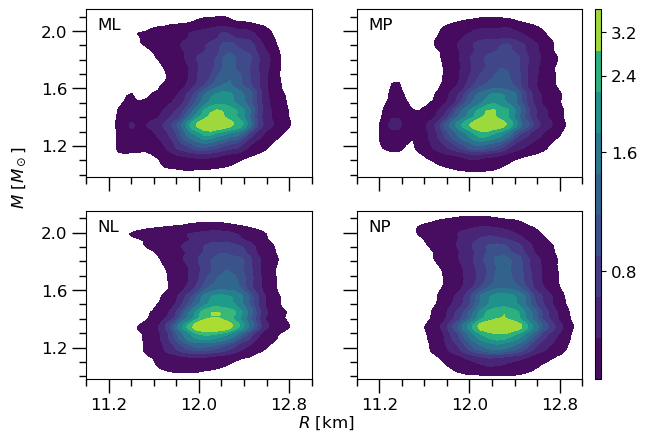

In [4]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
ax = ax.flatten()

for k in range(4):
    mchain = h5py.File('aff_inv/'+model[k]+'_all','r')['markov_chain_0']
    mmax = np.array(mchain['data']['M_max'])
    nrows = len(mmax)
    r = np.zeros((100, nrows))
    for i in range(100):
        r[i] = np.array(mchain['data']['R_'+str(i)])
    r=r.T
    m = np.arange(0.2, 0.2+((3-0.2)/99)*r.shape[1], ((3-0.2)/99))
    M_gw, R_gw = np.zeros((4, nrows)), np.zeros((4, nrows))
    for j in range(4):
        M_gw[j] = np.array(mchain['data/'+m_gw[j]])
    M_nsp, R_nsp = np.zeros((len(m_pop), nrows)), np.zeros((len(m_pop), nrows))
    M_src, R_src = np.zeros((len(m_em), nrows)), np.zeros((len(m_em), nrows))

    for j in range(4):
        for i in range(nrows):
            R_gw[j][i] = np.interp(M_gw[j][i], m, r[i])
    for j in range(len(m_pop)):
        M_nsp[j] = np.array(mchain['data/'+m_pop[j]])
        for i in range(nrows):
            R_nsp[j][i] = np.interp(M_nsp[j][i], m, r[i])
    for j in range(len(m_em)):
        M_src[j] = np.array(mchain['data/'+m_em[j]])
        R_src[j] = np.array(mchain['data/'+r_em[j]])

    M = np.concatenate((M_gw, M_nsp, M_src), axis=0).flatten()
    R = np.concatenate((R_gw, R_nsp, R_src), axis=0).flatten()

    h = sns.kdeplot(x=R, y=M, ax=ax[k], fill=True, cmap='viridis')
    ax[k].text(0.05, 0.95, label[k], transform=ax[k].transAxes, \
               verticalalignment='top')
    ax[k].set_xlim(11, 13)
    ax[k].set_ylim(min(M)-0.02, 2.15)
    ax[k].minorticks_on()
    ax[k].tick_params('both', length=10, width=1, which='major')
    ax[k].tick_params('both', length=5,  width=1, which='minor')
    ax[k].xaxis.set_major_locator(MaxNLocator(nbins=3))
    ax[k].yaxis.set_major_locator(MaxNLocator(nbins=3))

cax = fig.add_axes([0.92, 0.11, 0.01, 0.77]) # [left, bottom, width, height]
cb = fig.colorbar(h.collections[0], cax=cax)
cb.locator = MaxNLocator(nbins=5)
cb.update_ticks()

fig.text(0.5, 0.02, r'$R$ [km]', ha='center', va='center')
fig.text(0.02, 0.53, r'$M$ [$M_\odot$]', ha='center', va='center', \
         rotation='vertical')
plt.show()

### 1.3 Central Pressures vs. Energy Densities

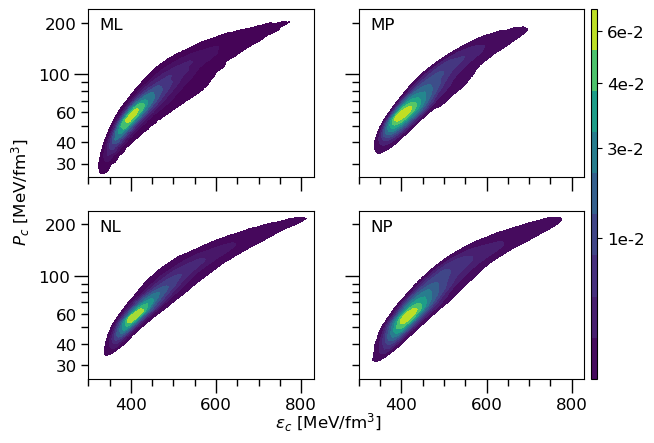

In [5]:
def custom_scientific(x, pos):
    return f'{x:.0e}'.replace('e-0', 'e-').replace('e+00','')

def fixed_major(x, pos):
    return f'{x:.0f}'

def fixed_minor(x, pos):
    if x in [30, 40, 60, 200]:
        return f'{x:.0f}'
    else:
        return ''
    
hc = 197.32698

fig, ax = plt.subplots(2, 2, sharey=True, sharex=True)
ax = ax.flatten()
for k in range(4):
    mchain = h5py.File('aff_inv/'+model[k]+'_all','r')['markov_chain_0']
    mmax = np.array(mchain['data']['M_max'])
    nrows = len(mmax)
    pm, p = np.zeros((100, nrows)), np.zeros((100, nrows))
    for i in range(100):
        pm[i] = np.array(mchain['data']['PM_'+str(i)])*hc
        p[i] = np.array(mchain['data']['P_'+str(i)])*hc
    pm=pm.T; p=p.T
    m = np.arange(0.2, 0.2+((3-0.2)/99)*pm.shape[1], (3-0.2)/99)
    e = np.arange(0.3*hc, 0.3*hc+((10-0.3)*hc/99)*pm.shape[1], (10-0.3)*hc/99)
    M_gw, M_nsp, M_src = np.zeros((4,nrows)), np.zeros((len(m_pop),nrows)), np.zeros((len(m_em),nrows))
    PM_gw, P_gw, E_gw = np.zeros_like(M_gw), np.zeros_like(M_gw), np.zeros_like(M_gw)
    PM_nsp, P_nsp, E_nsp = np.zeros_like(M_nsp), np.zeros_like(M_nsp), np.zeros_like(M_nsp)
    PM_src, P_src, E_src = np.zeros_like(M_src), np.zeros_like(M_src), np.zeros_like(M_src)
    for j in range(4):
        M_gw[j] = np.array(mchain['data/'+m_gw[j]])

    for j in range(4):
        for i in range(nrows):
            P_gw[j][i] = np.interp(M_gw[j][i], m, pm[i])
            E_gw[j][i] = np.interp(P_gw[j][i], p[i], e)
    for j in range(len(m_pop)):
        M_nsp[j] = np.array(mchain['data/'+m_pop[j]])
        for i in range(nrows):
            P_nsp[j][i] = np.interp(M_nsp[j][i], m, pm[i])
            E_nsp[j][i] = np.interp(P_nsp[j][i], p[i], e)
    for j in range(len(m_em)):
        M_src[j] = np.array(mchain['data/'+m_em[j]])
        for i in range(nrows):
            P_src[j][i] = np.interp(M_src[j][i], m, pm[i])
            E_src[j][i] = np.interp(P_src[j][i], p[i], e)

    P = np.concatenate((P_gw, P_nsp, P_src), axis=0).flatten()
    E = np.concatenate((E_gw, E_nsp, E_src), axis=0).flatten()

    h = sns.kdeplot(x=E, y=P, ax=ax[k], fill=True, cmap='viridis')
    ax[k].text(0.05, 0.95, label[k], transform=ax[k].transAxes, \
                   verticalalignment='top')
    ax[k].set_yscale('log')
    ax[k].yaxis.set_major_formatter(FuncFormatter(fixed_major))
    ax[k].yaxis.set_minor_formatter(FuncFormatter(fixed_minor))
    ax[k].set_xlim(300, 830)
    ax[k].set_ylim(2.5e1, 2.4e2)
    ax[k].minorticks_on()
    ax[k].tick_params('both', length=10, width=1, which='major')
    ax[k].tick_params('both', length=5,  width=1, which='minor')

cax = fig.add_axes([0.91, 0.11, 0.01, 0.77]) # [left, bottom, width, height]
cbr = fig.colorbar(h.collections[0], cax=cax, \
                   format=FuncFormatter(custom_scientific))
cbr.locator = MaxNLocator(nbins=5)
cbr.update_ticks()

fig.text(0.5, 0.02, r'$\epsilon_c$ [MeV/fm$^3$]', ha='center', va='center')
fig.text(0.02, 0.5, r'$P_c$ [MeV/fm$^3$]', ha='center', va='center', \
         rotation='vertical')
plt.show()

### 1.4 Tidal Deformabilities vs. Masses

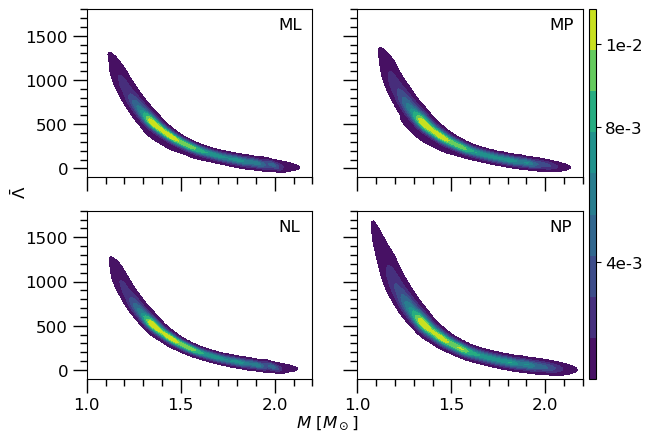

In [6]:
def custom_scientific(x, pos):
    return f'{x:.0e}'.replace('e-0', 'e-').replace('e+00','')

def fixed_major(x, pos):
    return f'{x:.0f}'

def fixed_minor(x, pos):
    return ''

fig, ax = plt.subplots(2, 2, sharey=True, sharex=True)
ax = ax.flatten()
for k in range(4):
    mchain = h5py.File('aff_inv/'+model[k]+'_all','r')['markov_chain_0']
    mmax = np.array(mchain['data']['M_max'])
    nrows = len(mmax)
    ti = np.zeros((100, nrows))
    for i in range(100):
        ti[i] = np.array(mchain['data']['Lambda_bar_'+str(i)])
    ti=ti.T
    m = np.arange(0.2, 0.2+((3-0.2)/99)*ti.shape[1], ((3-0.2)/99))
    M_gw, L_gw = np.zeros((4, nrows)), np.zeros((4, nrows))
    for j in range(4):
        M_gw[j] = np.array(mchain['data/'+m_gw[j]])
    M_nsp, L_nsp = np.zeros((len(m_pop), nrows)), np.zeros((len(m_pop), nrows))
    M_src, L_src = np.zeros((len(m_em), nrows)), np.zeros((len(m_em), nrows))

    for j in range(4):
        for i in range(nrows):
            L_gw[j][i] = np.interp(M_gw[j][i], m, ti[i])
    for j in range(len(m_pop)):
        M_nsp[j] = np.array(mchain['data/'+m_pop[j]])
        for i in range(nrows):
            L_nsp[j][i] = np.interp(M_nsp[j][i], m, ti[i])
    for j in range(len(m_em)):
        M_src[j] = np.array(mchain['data/'+m_em[j]])
        for i in range(nrows):
            L_src[j][i] = np.interp(M_src[j][i], m, ti[i])

    M = np.concatenate((M_gw, M_nsp, M_src), axis=0).flatten()
    L = np.concatenate((L_gw, L_nsp, L_src), axis=0).flatten()

    h = sns.kdeplot(x=M, y=L, ax=ax[k], fill=True, cmap='viridis')
    ax[k].text(0.85, 0.95, label[k], transform=ax[k].transAxes, \
                   verticalalignment='top')
    #ax[k].set_yscale('log')
    ax[k].set_xlim(1.0, 2.2)
    ax[k].set_ylim(min(L)-100, 1800)
    ax[k].yaxis.set_major_formatter(FuncFormatter(fixed_major))
    ax[k].yaxis.set_minor_formatter(FuncFormatter(fixed_minor))
    ax[k].set_ylabel('')
    ax[k].minorticks_on()
    ax[k].tick_params('both', length=10, width=1, which='major')
    ax[k].tick_params('both', length=5,  width=1, which='minor')
    ax[k].xaxis.set_major_locator(plt.MaxNLocator(nbins=3))

cax = fig.add_axes([0.91, 0.11, 0.01, 0.77]) # [left, bottom, width, height]
cb = fig.colorbar(h.collections[0], cax=cax, \
                  format=FuncFormatter(custom_scientific))
cb.locator = MaxNLocator(nbins=4)
cb.update_ticks()

fig.text(0.5, 0.02, r'$M$ [$M_\odot$]', ha='center', va='center')
fig.text(0.02, 0.5, r'$\bar{\Lambda}$', ha='center', va='center', \
         rotation='vertical')
plt.show()

### 1.5 Masses

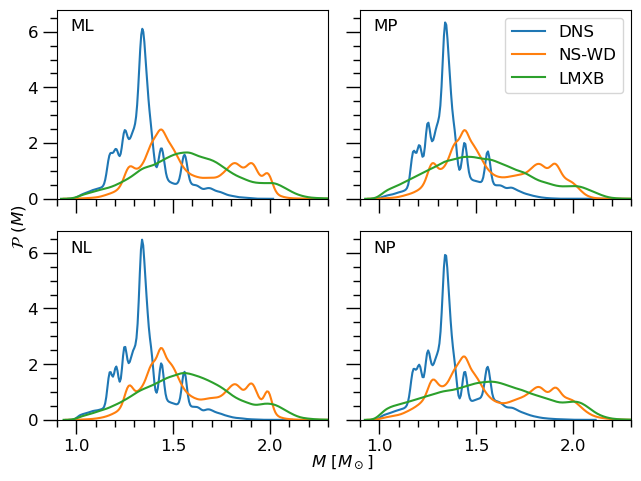

In [7]:
nsns = ['m1_gw17', 'm2_gw17', 'm1_gw19', 'm2_gw19', 'M_J0453p','M_J0453c','M_J1906p',
        'M_J1906c','M_B1534p','M_B1534c','M_B1913p','M_B1913c','M_B2127p','M_B2127c',
        'M_J0737A','M_J0737B','M_J1756p','M_J1756c','M_J1807p','M_J1807c',
        'M_J1518p','M_J1518c','M_J1811p','M_J1811c','M_J1829p','M_J1829c']
nswd = ['M_J2045', 'M_J2053', 'M_J1713', 'M_B1855', 'M_J0751', 'M_J1141', 'M_J1738', 'M_J1614', 
        'M_J0348', 'M_J2222', 'M_J2234', 'M_J1949', 'M_J1012', 'M_J0437', 'M_J1909', 'M_J1802',
        'M_J1911', 'M_J2043', 'M_J0337', 'M_J1946', 'M_J1918', 'M_J1600', 'M_J0621', 'M_B2303',
        'M_J0024', 'M_J0514', 'M_B1516', 'M_J1748I','M_J1748J','M_B1802', 'M_B1911', 'M_J0740']
lmxb = ['M_CygX2',  'M_XTEJ2123', 'M_4U1822', 'M_HerX1',  'M_2S0921', 'Mns_6304',  'Mns_6397',
        'Mns_M13',  'Mns_M28',    'Mns_M30',  'Mns_wCen', 'Mns_X7',   'Mns_1810b', 'Mns_1724b', 
        'Mns_1702', 'Mns_0030',   'Mns_0740']

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
ax = ax.flatten()

for k in range(4):
    mchain = h5py.File('aff_inv/'+model[k]+'_all')['markov_chain_0']
    mmax = np.array(mchain['data']['M_max'])
    nrows = len(mmax)
    M_ns = np.zeros((len(nsns),nrows))
    M_wd = np.zeros((len(nswd),nrows))
    M_lx = np.zeros((len(lmxb),nrows))
    for j in range(len(nsns)):
        M_ns[j] = np.array(mchain['data/'+nsns[j]])
    for j in range(len(nswd)):
        M_wd[j] = np.array(mchain['data/'+nswd[j]])
    for j in range(len(lmxb)):
        M_lx[j] = np.array(mchain['data/'+lmxb[j]])
    sns.kdeplot(M_ns.flatten(), ax=ax[k], label='DNS')
    sns.kdeplot(M_wd.flatten(), ax=ax[k], label='NS-WD')
    sns.kdeplot(M_lx.flatten(), ax=ax[k], label='LMXB')
    ax[k].text(0.05, 0.95, label[k], transform=ax[k].transAxes, \
                   verticalalignment='top')
    ax[k].set_ylabel('')
    ax[k].set_xlim(0.9, 2.3)
    ax[k].minorticks_on()
    ax[k].tick_params('both', length=10, width=1, which='major')
    ax[k].tick_params('both', length=5,  width=1, which='minor')

ax[1].legend()

fig.text(0.52, 0.02, r'$M$ [$M_\odot$]', ha='center', va='center')
fig.text(0.015, 0.51, r'$\mathcal{P}~(M)$', ha='center', va='center', \
         rotation='vertical')
fig.tight_layout()
plt.show()

### 1.6 Mass - Radius Curves

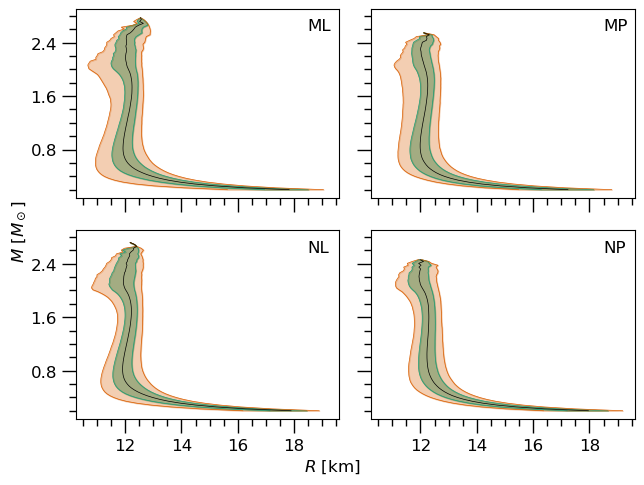

In [8]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
ax = ax.flatten()
for k in range(4):
    mchain = h5py.File('aff_inv/'+model[k]+'_all','r')['markov_chain_0']
    mmax = np.array(mchain['data']['M_max'])
    nrows = len(mmax)
    
    m, r, rm = [], [], []
    r68_lo, r68_hi, r95_lo, r95_hi = [], [], [], []
    for j in range(100):
        rd = np.array(mchain['data']['R_'+str(j)])
        if np.any(rd > 0):
            r.append(rd[np.nonzero(rd)])
    for j in range(len(r)):
        r68_lo.append(np.percentile(r[j], 16))
        r68_hi.append(np.percentile(r[j], 84))
        r95_lo.append(np.percentile(r[j], 2.5))
        r95_hi.append(np.percentile(r[j], 97.5))
        rm.append(np.median(r[j]))

    m = np.arange(0.2, 0.2+((3-0.2)/99)*len(rm), ((3-0.2)/99))

    ax[k].plot(r68_lo, m, color='#1b9e77', lw=0.5)
    ax[k].plot(r68_hi, m, color='#1b9e77', lw=0.5)
    ax[k].plot(r95_lo, m, color='#d95f02', lw=0.5)
    ax[k].plot(r95_hi, m, color='#d95f02', lw=0.5)
    ax[k].plot(rm, m, label='median', color='black', lw=0.5)
    ax[k].fill_betweenx(m, r68_lo, r68_hi, color='#1b9e77', alpha=0.5)
    ax[k].fill_betweenx(m, r95_lo, r95_hi, color='#d95f02', alpha=0.3)
    ax[k].text(0.88, 0.95, label[k], transform=ax[k].transAxes, \
                   verticalalignment='top')
    #ax[k].set_xlim(11.5, 13)
    #ax[k].set_ylim(0, 2.3)
    ax[k].minorticks_on()
    ax[k].tick_params('both', length=10, width=1, which='major')
    ax[k].tick_params('both', length=5,  width=1, which='minor')
    #ax[k].xaxis.set_major_locator(MaxNLocator(nbins=4))
    ax[k].yaxis.set_major_locator(MaxNLocator(nbins=4))

fig.text(0.5, 0.01, r'$R~[\mathrm{km}]$', ha='center', va='center')
fig.text(0.01, 0.5, r'$M~[M_\odot]$', ha='center', va='center', \
         rotation='vertical')
fig.tight_layout()
plt.show()

In [9]:
    #r = [None] * 100  # Initialize r as a list to hold arrays
    #for i in range(100):
    #  r[i] = np.array(mchain['data']['R_'+str(i)])
    #  r[i] = r[i][np.nonzero(r[i])].tolist() 
    #  if r[i]==[]:
    #    r[i] = 0
    #  else:
    #    r[i] = np.mean(r[i])
    #r = np.array(r)[np.nonzero(np.array(r))]
    #m = np.arange(0.2, 0.2+((3-0.2)/99)*len(r), ((3-0.2)/99))
    #for i in range(len(m)):
    #   if m[i] > mmax:
    #      m[i] = 0
    #      r[i] = 0
    #r = r[np.nonzero(r)]
    #m = m[np.nonzero(m)]

### 1.7 Equations of State

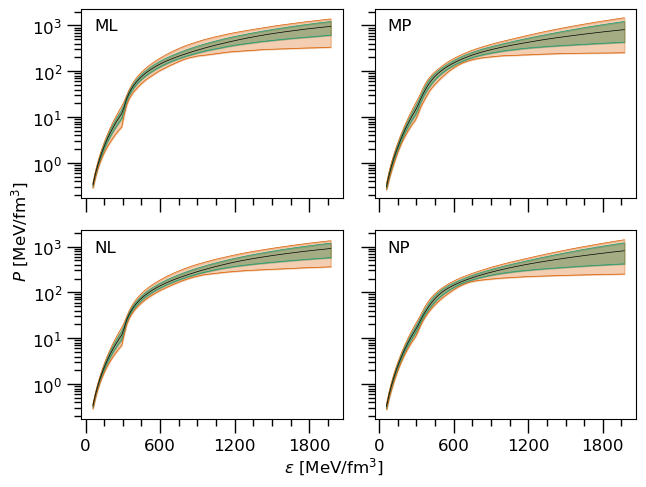

In [10]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
ax = ax.flatten()
for k in range(4):
    mchain = h5py.File('aff_inv/'+model[k]+'_all','r')['markov_chain_0']
    mmax = np.array(mchain['data']['M_max'])
    nrows = len(mmax)
    
    e, p, pm = [], [], []
    p68_lo, p68_hi, p95_lo, p95_hi = [], [], [], []
    for j in range(100):
        pr = np.array(mchain['data']['P_'+str(j)])*hc
        if np.any(pr > 0):
            p.append(pr[np.nonzero(pr)])
    for j in range(len(p)):
        p68_lo.append(np.percentile(p[j], 16))
        p68_hi.append(np.percentile(p[j], 84))
        p95_lo.append(np.percentile(p[j], 2.5))
        p95_hi.append(np.percentile(p[j], 97.5))
        pm.append(np.median(p[j]))

    e = np.arange(0.3*hc, 0.3*hc+((10-0.3)*hc/99)*len(p), (10-0.3)*hc/99)

    ax[k].plot(e, p68_lo, color='#1b9e77', lw=0.5)
    ax[k].plot(e, p68_hi, color='#1b9e77', lw=0.5)
    ax[k].plot(e, p95_lo, color='#d95f02', lw=0.5)
    ax[k].plot(e, p95_hi, color='#d95f02', lw=0.5)
    ax[k].plot(e, pm, label='median', color='black', lw=0.5)
    ax[k].fill_between(e, p68_lo, p68_hi, color='#1b9e77', alpha=0.5)
    ax[k].fill_between(e, p95_lo, p95_hi, color='#d95f02', alpha=0.3)
    ax[k].text(0.05, 0.95, label[k], transform=ax[k].transAxes, \
                   verticalalignment='top')
    ax[k].set_yscale('log')
    ax[k].minorticks_on()
    ax[k].tick_params('both', length=10, width=1, which='major')
    ax[k].tick_params('both', length=5,  width=1, which='minor')
    ax[k].xaxis.set_major_locator(MaxNLocator(nbins=4))
    #ax[k].yaxis.set_major_locator(MaxNLocator(nbins=4))

fig.text(0.5, 0.01, r'$\epsilon~[\mathrm{MeV/fm}^3]$', ha='center', va='center')
fig.text(0.01, 0.5, r'$P~[\mathrm{MeV/fm}^3]$', ha='center', va='center', \
         rotation='vertical')
fig.tight_layout()
plt.show()

### 1.8 Speed of Sound

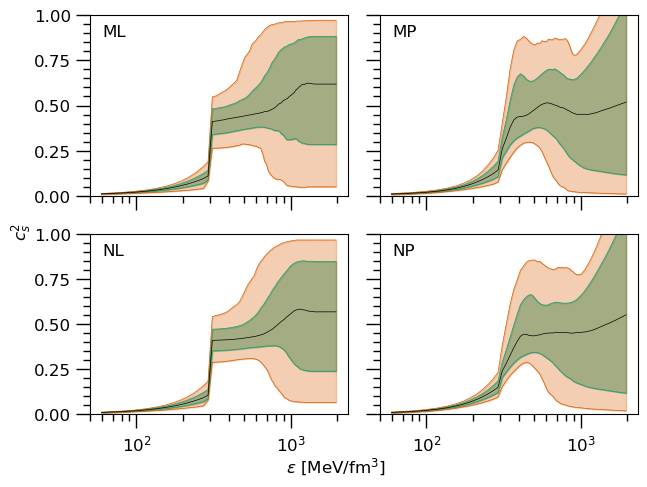

In [44]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
ax = ax.flatten()
for k in range(4):
    mchain = h5py.File('aff_inv/'+model[k]+'_all','r')['markov_chain_0']
    mmax = np.array(mchain['data']['M_max'])
    nrows = len(mmax)
    
    cs, csm = [], []
    c68_lo, c68_hi, c95_lo, c95_hi = [], [], [], []
    
    for j in range(100):
        cs.append(np.array(mchain['data']['cs2_'+str(j)]))

    for j in range(len(cs)):
        c68_lo.append(np.percentile(cs[j], 16))
        c68_hi.append(np.percentile(cs[j], 84))
        c95_lo.append(np.percentile(cs[j], 2.5))
        c95_hi.append(np.percentile(cs[j], 97.5))
        csm.append(np.median(cs[j]))

    ed = np.linspace(0.3*hc, 10*hc, 100)

    ax[k].plot(ed, c68_lo, color='#1b9e77', lw=0.5)
    ax[k].plot(ed, c68_hi, color='#1b9e77', lw=0.5)
    ax[k].plot(ed, c95_lo, color='#d95f02', lw=0.5)
    ax[k].plot(ed, c95_hi, color='#d95f02', lw=0.5)
    ax[k].plot(ed, csm, label='median', color='black', lw=0.5)
    ax[k].fill_between(ed, c68_lo, c68_hi, color='#1b9e77', alpha=0.5)
    ax[k].fill_between(ed, c95_lo, c95_hi, color='#d95f02', alpha=0.3)
    ax[k].text(0.05, 0.95, label[k], transform=ax[k].transAxes, \
                   verticalalignment='top')
    ax[k].set_xscale('log')
    ax[k].set_ylim(0, 1)
    ax[k].minorticks_on()
    ax[k].tick_params('both', length=10, width=1, which='major')
    ax[k].tick_params('both', length=5,  width=1, which='minor')
    #ax[k].xaxis.set_major_locator(MaxNLocator(nbins=4))
    ax[k].yaxis.set_major_locator(MaxNLocator(nbins=4))

fig.text(0.5, 0.01, r'$\epsilon~[\mathrm{MeV/fm}^3]$', ha='center', va='center')
fig.text(0.01, 0.5, r'$c_s^2$', ha='center', va='center', \
         rotation='vertical')
fig.tight_layout()
plt.show()

### 1.9 Energy vs. Baryon Density

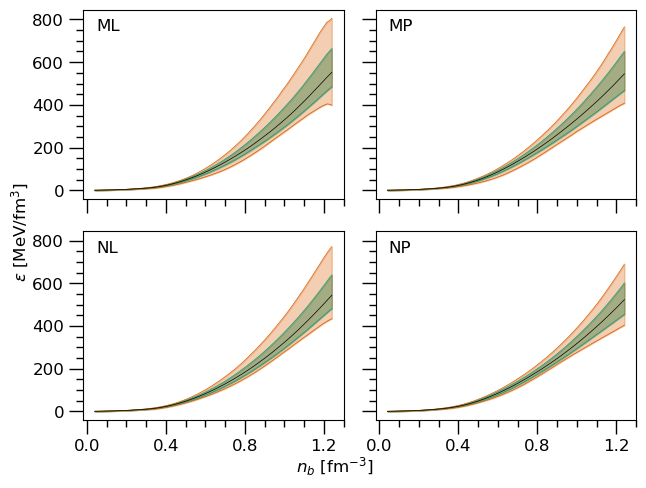

In [56]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
ax = ax.flatten()
for k in range(4):
    mchain = h5py.File('aff_inv/'+model[k]+'_all','r')['markov_chain_0']
    mmax = np.array(mchain['data']['M_max'])
    nrows = len(mmax)
    
    eoa, eoam = [], []
    e68_lo, e68_hi, e95_lo, e95_hi = [], [], [], []
    
    for j in range(100):
        eoa.append(np.array(mchain['data']['EoA_'+str(j)])*hc)

    for j in range(len(eoa)):
        e68_lo.append(np.percentile(eoa[j], 16))
        e68_hi.append(np.percentile(eoa[j], 84))
        e95_lo.append(np.percentile(eoa[j], 2.5))
        e95_hi.append(np.percentile(eoa[j], 97.5))
        eoam.append(np.median(eoa[j]))

    nb = np.linspace(0.04, 1.24, 100)

    ax[k].plot(nb, e68_lo*nb, color='#1b9e77', lw=0.5)
    ax[k].plot(nb, e68_hi*nb, color='#1b9e77', lw=0.5)
    ax[k].plot(nb, e95_lo*nb, color='#d95f02', lw=0.5)
    ax[k].plot(nb, e95_hi*nb, color='#d95f02', lw=0.5)
    ax[k].plot(nb, eoam*nb, label='median', color='black', lw=0.5)
    ax[k].fill_between(nb, e68_lo*nb, e68_hi*nb, color='#1b9e77', alpha=0.5)
    ax[k].fill_between(nb, e95_lo*nb, e95_hi*nb, color='#d95f02', alpha=0.3)
    ax[k].text(0.05, 0.95, label[k], transform=ax[k].transAxes, \
                   verticalalignment='top')
    #ax[k].set_yscale('log')
    ax[k].minorticks_on()
    ax[k].tick_params('both', length=10, width=1, which='major')
    ax[k].tick_params('both', length=5,  width=1, which='minor')
    ax[k].xaxis.set_major_locator(MaxNLocator(nbins=4))
    #ax[k].yaxis.set_major_locator(MaxNLocator(nbins=4))

fig.text(0.5, 0.01, r'$n_b~[\mathrm{fm}^{-3}]$', ha='center', va='center')
fig.text(0.01, 0.5, r'$\epsilon~[\mathrm{MeV/fm}^3]$', ha='center', \
         va='center', rotation='vertical')
fig.tight_layout()
plt.show()

### 1.10 Mass Distributions

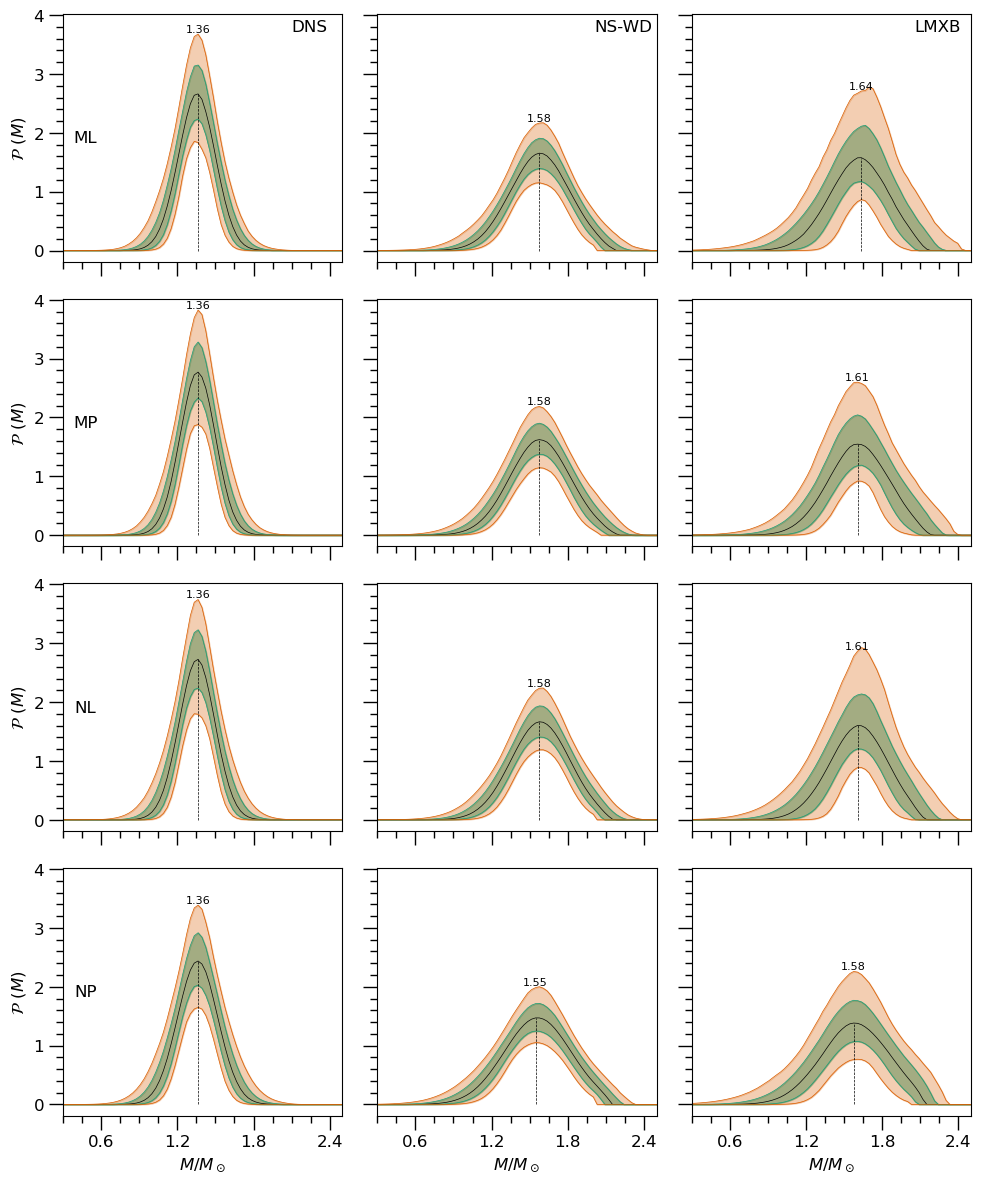

In [68]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy.stats as st
from matplotlib.ticker import MaxNLocator

def f_sn(x, mean, width, skewness):
    cf = 1/np.sqrt(2*np.pi)/width
    pdf = np.exp(-0.5*((x-mean)/width)**2)
    cdf = 1.0+sp.erf((x-mean)*skewness/width/np.sqrt(2.0))
    return cf*pdf*cdf

# Data labels
pop = ['NS', 'WD', 'LMS']  # Population categories
pname = ['DNS', 'NS-WD', 'LMXB']  # Population names
label = ['ML', 'MP', 'NL', 'NP']  # Model labels

# Create figure with subplots (4 rows, 3 columns)
fig, ax = plt.subplots(4, 3, figsize=(10, 12), sharex=True, sharey=True)
ax = ax.flatten()

# Loop over models (rows)
for l in range(4):
    mchain = h5py.File('aff_inv/'+model[l]+'_all','r')['markov_chain_0']
    mmax = np.array(mchain['data']['M_max'])
    nrows = len(mmax)
    
    # Initialize m range and fsn storage
    m = np.linspace(0.0, 3, 100)
    fsn = np.zeros((3, nrows, 100))  # [population, rows, m-values]
    fsnm = np.zeros((3, 100))  # [population, m-values]
    
    # Storage for confidence intervals
    f68_lo, f68_hi = np.zeros((3, 100)), np.zeros((3, 100))
    f95_lo, f95_hi = np.zeros((3, 100)), np.zeros((3, 100))
    
    # Loop over populations (NS, WD, LMS)
    for i in range(3):
        mean = np.array(mchain['data']['mean_'+pop[i]])
        widt = np.array(mchain['data']['log10_width_'+pop[i]])
        skew = np.array(mchain['data']['skewness_'+pop[i]])
        
        # Calculate skewnorm PDF for each row
        for j in range(nrows):
            fsn[i][j] = st.skewnorm.pdf(m, loc=mean[j], scale=10**widt[j], a=skew[j])

    # Set PDF values to zero for m > M_max
    for i in range(3):
        for j in range(nrows):
            for k in range(100):
                if m[k] > mmax[j]:
                    fsn[i][j][k] = 0
    
    # Calculate percentiles for each population across rows
    for i in range(3):
        f68_lo[i] = np.percentile(fsn[i], 16, axis=0)  # 68% lower bound
        f68_hi[i] = np.percentile(fsn[i], 84, axis=0)  # 68% upper bound
        f95_lo[i] = np.percentile(fsn[i], 2.5, axis=0) # 95% lower bound
        f95_hi[i] = np.percentile(fsn[i], 97.5, axis=0) # 95% upper bound
        fsnm[i] = np.median(fsn[i], axis=0)  # Median

    # Plotting for each population (NS, WD, LMS)
    for i in range(3):
        # Plot the median and confidence intervals
        ax[l*3+i].plot(m, fsnm[i], color='black', lw=0.5)
        ax[l*3+i].plot(m, f68_lo[i], color='#1b9e77', lw=0.5)
        ax[l*3+i].plot(m, f68_hi[i], color='#1b9e77', lw=0.5)
        ax[l*3+i].plot(m, f95_lo[i], color='#d95f02', lw=0.5)
        ax[l*3+i].plot(m, f95_hi[i], color='#d95f02', lw=0.5)
        ax[l*3+i].fill_between(m, f68_lo[i], f68_hi[i], color='#1b9e77', alpha=0.5)
        ax[l*3+i].fill_between(m, f95_lo[i], f95_hi[i], color='#d95f02', alpha=0.3)

        # Find the peak of the median curve
        peak_index = np.argmax(fsnm[i])
        peak_x = m[peak_index]
        peak_y = fsnm[i][peak_index]

        # Find the y-value of the 95% upper bound at the peak x
        upper_95_at_peak = f95_hi[i][peak_index]

        # Draw a vertical dashed line from 0 to the peak
        ax[l*3+i].plot([peak_x, peak_x], [0, peak_y], color='black', lw=0.5, linestyle='--')
        
        # Display the x-value of the peak at the top of the upper 95% CI curve
        ax[l*3+i].text(peak_x, upper_95_at_peak, f'{peak_x:.2f}', ha='center', \
                       va='bottom', fontsize=8, color='black')
        
        # Formatting
        ax[l*3+i].set_xlim(0.3, 2.5)
        ax[l*3+i].minorticks_on()
        ax[l*3+i].tick_params('both', length=10, width=1, which='major')
        ax[l*3+i].tick_params('both', length=5,  width=1, which='minor')
        ax[l*3+i].xaxis.set_major_locator(MaxNLocator(nbins=4))
        
        # Adding titles and labels
        if l*3+i < 3:
            ax[l*3+i].text(0.88, 0.95, pname[i], transform=ax[l*3+i].transAxes, \
                    verticalalignment='center', ha='center')
        if (l*3+i) % 3 == 0:
            ax[l*3+i].text(0.08, 0.5, label[l], transform=ax[l*3+i].transAxes, \
                    verticalalignment='center', ha='center')
            ax[l*3+i].set_ylabel(r'$\mathcal{P}~(M)$')
        if l*3+i > 8:
            ax[l*3+i].set_xlabel(r'$M/M_\odot$')

# Customizing the plot layout
plt.tight_layout()
plt.show()


## 2. Computational Analysis

### 2.1 Autocorrelation Lengths

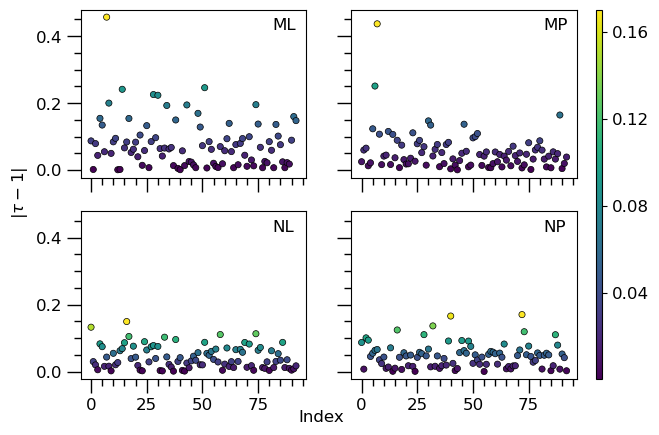

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import emcee as mc  # Assuming you're using emcee for autocorr
from matplotlib.ticker import MaxNLocator

names = ['a', 'alpha', 'param_S', 'param_L', '', 'trans1', '', 'trans2', '', 
        'M_chirp_det', 'q', 'z_cdf', 'm1_gw19', 'mf_6304', 'mf_6397', 'mf_M13',
        'mf_M28', 'mf_M30', 'mf_wCen', 'mf_X7', 'mf_1810b', 'mf_1724b', 'mf_1702', 
        'mf_0030', 'mf_0740', 'mean_NS', 'log10_width_NS', 'skewness_NS', 'mean_WD', 
        'log10_width_WD', 'skewness_WD', 'mean_LMS', 'log10_width_LMS', 'skewness_LMS',
        'M_J0453p', 'M_J0453c', 'M_J1906p', 'M_J1906c', 'M_B1534p', 'M_B1534c',
        'M_B1913p', 'M_B1913c', 'M_B2127p', 'M_B2127c', 'M_J0737A', 'M_J0737B',
        'M_J1756p', 'M_J1756c', 'M_J1807p', 'M_J1807c', 'M_J1518p', 'M_J1518c',
        'M_J1811p', 'M_J1811c', 'M_J1829p', 'M_J1829c', 'M_J2045',  'M_J2053',
        'M_J1713',  'M_B1855',  'M_J0751',  'M_J1141',  'M_J1738',  'M_J1614',
        'M_J0348',  'M_J2222',  'M_J2234',  'M_J1949',  'M_J1012',  'M_J0437',
        'M_J1909',  'M_J1802',  'M_J1911',  'M_J2043',  'M_J0337',  'M_J1946',
        'M_J1918',  'M_J1600',  'M_J0621',  'M_B2303',  'M_J0024',  'M_J0514',
        'M_B1516',  'M_J1748I', 'M_J1748J', 'M_B1802',  'M_B1911',  'M_J0740',
        'M_CygX2',  'M_XTEJ2123', 'M_4U1822', 'M_HerX1',  'M_2S0921']

model = ['ml', 'mp', 'nl', 'np']
label = ['ML', 'MP', 'NL', 'NP']

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
ax = ax.flatten()

for k in range(4):
    if model[k] == 'mp' or model[k] == 'np':
        names[4], names[6], names[8] = 'exp1', 'exp2', 'exp3'
    else:
        names[4], names[6], names[8] = 'csq1', 'csq2', 'csq3'
    
    mchain = h5py.File('aff_inv/'+model[k]+'_all','r')['markov_chain_0']
    pars, acor = [], []
    for j in range(len(names)):
        pars.append(np.array(mchain['data/'+names[j]]))
        tau = mc.autocorr.integrated_time(pars[j])
        tau = np.array(tau[0], dtype=float)
        acor.append(tau)

    acor = np.array(acor)

    # Optionally plot |tau - 1|
    acor_diff = np.abs(acor - 1)
    
    # Scatter plot with color map and adjusted marker size
    sc = ax[k].scatter(np.arange(len(names)), acor_diff, c=acor_diff, \
                       s=20, cmap='viridis', edgecolor='black', linewidth=0.5)
    ax[k].text(0.85, 0.95, label[k], transform=ax[k].transAxes, \
               verticalalignment='top', fontsize=12)
    
    ax[k].minorticks_on()
    ax[k].tick_params('both', length=10, width=1, which='major')
    ax[k].tick_params('both', length=5,  width=1, which='minor')
    ax[k].xaxis.set_major_locator(MaxNLocator(nbins=5))

# Add a colorbar for reference
cx = fig.add_axes([0.93, 0.11, 0.01, 0.77])  # [left, bottom, width, height]
cb = fig.colorbar(sc, cax=cx, orientation='vertical')
cb.locator = MaxNLocator(nbins=5)
cb.update_ticks()

fig.text(0.5, 0.03, r'Index', ha='center', va='center', fontsize=12)
fig.text(0.03, 0.5, r'$|\tau - 1|$', ha='center', va='center', \
         rotation='vertical', fontsize=12)
plt.show()
